<a href="https://colab.research.google.com/github/ykitaguchi77/Colab_Scripts/blob/master/pdf_translate_fugumt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 概要

pdf形式の英語論文を翻訳するやつ

## 使い方や説明など

https://qiita.com/sakasegawa/items/f50aae7f3acf475411aa

## 注意

- pipのlayoutparserインストールのとこでruntime restartボタンが出るから初回実行時はrestart一回かける必要あり

## memo

DPI = 72 くらいでいいかも

by https://twitter.com/gyakuse

## 準備

In [ ]:
# Install libraries
!pip install layoutparser --q # Install the base layoutparser library with
!pip install layoutparser torchvision -- q && pip install --q "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!pip install "layoutparser[layoutmodels]" --q # Install DL layout model toolkit 
!apt-get install poppler-utils --q
!pip install reportlab --q
!pip install pypdf --q
!pip install transformers --q
!pip install sentencepiece --q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving atten.pdf to atten.pdf


In [ ]:
pdf_file_name = list(uploaded.keys())[0]
target_pdf_file_path = '/content/' + pdf_file_name
is_mihiraki = True

In [ ]:
# フォントをダウンロード
font_name = 'BIZUDGothic'
font_ttf = 'BIZUDGothic-Regular.ttf'
font_url = f'https://github.com/googlefonts/morisawa-biz-ud-gothic/raw/main/fonts/ttf/{font_ttf}'

!wget https://github.com/googlefonts/morisawa-biz-ud-gothic/raw/main/fonts/ttf/BIZUDGothic-Regular.ttf

--2023-02-10 11:13:29--  https://github.com/googlefonts/morisawa-biz-ud-gothic/raw/main/fonts/ttf/BIZUDGothic-Regular.ttf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/googlefonts/morisawa-biz-ud-gothic/main/fonts/ttf/BIZUDGothic-Regular.ttf [following]
--2023-02-10 11:13:30--  https://raw.githubusercontent.com/googlefonts/morisawa-biz-ud-gothic/main/fonts/ttf/BIZUDGothic-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4667376 (4.5M) [application/octet-stream]
Saving to: ‘BIZUDGothic-Regular.ttf’

BIZUDGothic-Regular 100%[===================>]   4.45M  --.-KB/s    in 0.02s   

2023

In [ ]:
%ls

atten.pdf  BIZUDGothic-Regular.ttf  sample_data/


## 実行

In [ ]:
DPI = 72

In [ ]:
# pdfを画像として読み込む
import pdf2image
import numpy as np
import matplotlib.pyplot as plt
def pdf_to_image(file_path, page_num):
    return np.asarray(pdf2image.convert_from_path(file_path, dpi = DPI)[page_num])

In [ ]:
# 特定のtext_blockがparagraph_blockに含まれているかチェック
def is_inside(paragraph_block, text_block):
    paragraph_width = paragraph_block.block.x_2 - paragraph_block.block.x_1
    paragraph_height = paragraph_block.block.y_2 - paragraph_block.block.y_1
    if paragraph_width > 300:
        allowable_error_pixel = 10
        return (text_block.block.x_1 >= paragraph_block.block.x_1 - allowable_error_pixel and text_block.block.y_1 >= paragraph_block.block.y_1 and
                text_block.block.x_2 <= paragraph_block.block.x_2 + allowable_error_pixel and text_block.block.y_2 <= paragraph_block.block.y_2 + allowable_error_pixel)
    else:
        allowable_error_pixel = 3
        return (text_block.block.x_1 >= paragraph_block.block.x_1 - allowable_error_pixel and text_block.block.y_1 >= paragraph_block.block.y_1 and
                text_block.block.x_2 <= paragraph_block.block.x_2 + allowable_error_pixel and text_block.block.y_2 <= paragraph_block.block.y_2 + allowable_error_pixel)

In [ ]:
def fill_cover(canvas, x, y, width, height):
    canvas.setFillColorRGB(1, 1, 1)
    # でかいパラグラフは検出精度悪いので補正する
    if width > 300:
        canvas.rect(
            x - 5,
            y,
            width + 10,
            height + 10,
            stroke=0,
            fill=1
        )
    else:
        canvas.rect(
            x,
            y,
            width,
            height,
            stroke=0,
            fill=1
        )

In [ ]:
def calc_fontsize(paragraph_width, paragraph_height, translated_text):
    return int(numpy.sqrt((paragraph_width) * (paragraph_height) / len(translated_text)))

In [ ]:
# pdfを読み込む
import cv2
import layoutparser as lp

pdf_pages, _ = lp.load_pdf(target_pdf_file_path, load_images=True, dpi=DPI)

In [ ]:
# レイアウト(物体)検出モデルを準備
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

config.yaml?dl=1: 8.19kB [00:01, 7.82kB/s]
model_final.pth?dl=1: 856MB [01:15, 11.3MB/s]                           
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [ ]:
from PIL import Image, ImageDraw, ImageFont

def get_max_font_size(paragraph_width, paragraph_height, translated_text, font_face="./BIZUDGothic-Regular.ttf", max_font_size=100):
    """
    指定された領域内で最大のフォントサイズを求める。
    :param text: 描画する文字列。
    :param font_face: フォント名。
    :param rectangle: 描画領域を表すタプル (x0, y0, x1, y1)。
    :param max_font_size: 最大フォントサイズ。デフォルトは 100。
    :return: 最大フォントサイズ。
    """
    for font_size in range(max_font_size, 0, -1):
        font = ImageFont.truetype(font_face, font_size)
        # 描画する文字列のサイズを求める
        text_width, text_height = font.getsize(translated_text)
        if text_width <= paragraph_width and text_height <= paragraph_height:
            return font_size
    return 0

In [ ]:
# フォント登録
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

pdfmetrics.registerFont(TTFont(font_name, font_ttf))

In [ ]:
# 翻訳モデル: fugumt
from transformers import pipeline

translator = pipeline('translation', model='staka/fugumt-en-ja')

/usr/local/lib/python3.8/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


■0 ページ目
792 612


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


170
The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring signiﬁcantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English- to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Tra

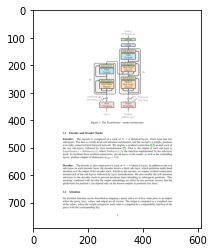

In [ ]:
from pypdf import PdfWriter, PdfReader
import io
from reportlab.platypus import BaseDocTemplate, PageTemplate
from reportlab.platypus import Paragraph, PageBreak, FrameBreak, KeepInFrame
from reportlab.platypus.flowables import Spacer
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib.pagesizes import A4, mm
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase import cidfonts
from reportlab.platypus.frames import Frame
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import numpy

# reportlab用の座標取る
base_pdf = PdfReader(open(target_pdf_file_path, "rb"))
_, _, base_width, base_height = base_pdf.pages[0].mediabox

output = PdfWriter()

for page_index, pdf_page in enumerate(pdf_pages):
    print("■%s ページ目" % page_index)
    # テキストブロックを取得
    text_blocks = pdf_page.get_homogeneous_blocks()
    # pdfを画像として取得
    pdf_image = pdf_to_image(target_pdf_file_path, page_index)
    # 座標取る
    height, width, channel = pdf_image.shape
    print(height, width)
    plt.imshow(pdf_image)
    # レイアウトを取得
    pdf_layout = model.detect(pdf_image)

    # 段落ブロックの処理
    # 段落ブロックを抽出
    paragraph_blocks = lp.Layout([b for b in pdf_layout if b.type=='Text'])

    cover_packet = io.BytesIO()
    cover_canvas = canvas.Canvas(cover_packet, pagesize=(int(base_width), int(base_height)), bottomup=True)

    text_packet = io.BytesIO()
    text_canvas = canvas.Canvas(text_packet, pagesize=(int(base_width), int(base_height)), bottomup=True)
    for paragraph_block in paragraph_blocks:
        # 段落中のテキストブロックを抽出
        inner_text_blocks = list(filter(lambda x: is_inside(paragraph_block, x), text_blocks))
        print(len(inner_text_blocks))
        if len(inner_text_blocks) == 0:
            continue
        # 段落中のテキストブロックからテキストを抽出
        text = " ".join(list(map(lambda x: x.text, inner_text_blocks)))
        print(text)
        # テキストを翻訳
        result = translator(text)
        translated_text = result[0]['translation_text']
        print(translated_text)
        paragraph_x = (paragraph_block.block.x_1 / width) * base_width
        paragraph_y = (paragraph_block.block.y_2 / height) * base_height
        paragraph_width = ((paragraph_block.block.x_2 - paragraph_block.block.x_1) / width) * base_width
        paragraph_height = ((paragraph_block.block.y_2 - paragraph_block.block.y_1) / height) * base_height

        # カバーフレームの追加
        fill_cover(cover_canvas, paragraph_x, height - paragraph_y, paragraph_width, paragraph_height)

        # テキストフレームの追加
        frame = Frame(paragraph_x, height - paragraph_y, paragraph_width, paragraph_height,
                            showBoundary=0, leftPadding=0, rightPadding=0, topPadding=0, bottomPadding=0)
        # テキスト実態の追加
        fontsize = calc_fontsize(paragraph_width, paragraph_height, translated_text)
        style = ParagraphStyle(name='Normal', fontName=font_name, fontSize=fontsize, leading=fontsize)
        paragraph = Paragraph(translated_text, style)
        story = [paragraph]
        story_inframe = KeepInFrame(paragraph_width * 1.5, paragraph_height * 1.5, story)
        frame.addFromList([story_inframe], text_canvas)


    # カバーをpdfページにする
    cover_canvas.save()

    cover_packet.seek(0)
    cover_pdf = PdfReader(cover_packet)

    # テキストをpdfページにする

    text_canvas.save()

    text_packet.seek(0)
    text_pdf = PdfReader(text_packet)

    # pdfをマージ
    base_pdf = PdfReader(open(target_pdf_file_path, "rb"))
    base_page = base_pdf.pages[page_index]
    # 見開き用
    if is_mihiraki:
        output.add_page(base_page)
    try:
        base_page.merge_page(cover_pdf.pages[0])
        base_page.merge_page(text_pdf.pages[0])
    except Exception as e:
        print("error: %s" % e)
    

    output.add_page(base_page)

# 保存
# pdfの出力パス
output_filepath = "translated_" + pdf_file_name
print(output_filepath)
outputStream = open(output_filepath, "wb")
output.write(outputStream)
outputStream.close()
files.download(output_filepath)